# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\trent\Desktop\BEE4750\hw3-shabazz`
   Installed Pango_jll ─────────────── v1.52.2+0
   Installed InlineStrings ─────────── v1.4.2
   Installed PtrArrays ─────────────── v1.2.0
   Installed Calculus ──────────────── v0.5.1
   Installed SentinelArrays ────────── v1.4.5
   Installed HypergeometricFunctions ─ v0.3.23
   Installed TranscodingStreams ────── v0.11.1
   Installed StatsFuns ─────────────── v1.3.1
   Installed Tables ────────────────── v1.12.0
   Installed Rmath_jll ─────────────── v0.4.2+0
   Installed DualNumbers ───────────── v0.6.8
   Installed Rmath ─────────────────── v0.7.1
   Installed QuadGK ────────────────── v2.9.4
   Installed FillArrays ────────────── v1.11.0
   Installed Distributions ─────────── v0.25.109
Precompiling project...
  ✓ Calculus
  ✓ PtrArrays
  ✓ InlineStrings
  ✓ FillArrays
  ✓ SentinelArrays
  ✓ PooledArrays
  ✓ TranscodingStreams
  ✓ Tables
  ✓ Rmath_jll
  ✓ OpenSpecFun_jll
  ✓ FilePathsBase
  ✓ Dbus_jll
  ✓ AliasT

In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [11]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

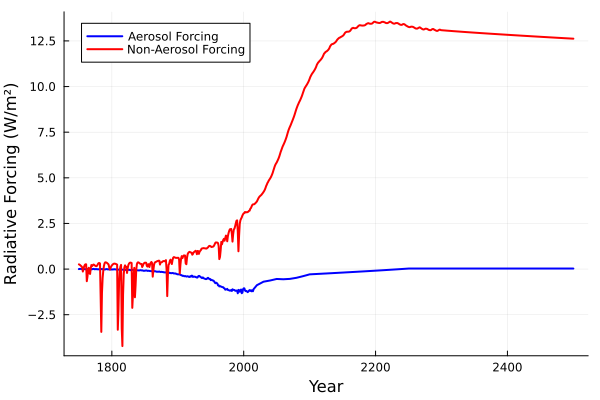

In [1]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

***EXPLANATION***
We made a function "simulate_temperature" that returns expected temperatures over time given lambda, radiative forcing, heat capacity, and time step. We used this to calculate the estimate with lambda=2.1, for years from preindustrial to 2500. 
This function makes an empty array for temperature up to a given time, and then for each time, updates the tempeartre based on the difference between radiative forcing and lambda*T.

For the monte carlo simulation, 1000 different lambda values were sampled from the log-normal dist., then a histogram was made of the 1000 values. Also, a similar fucntion to the monte carlo lab was used to make a plot of the cumulative mean of lambda values over iteration numbers. The simulate_temperature fucntion is called for each of the lambdas for the year 2100, and thats how I made the confidence interval, with 1000 estimates. We chose 1000 iterations for the monte carlo simulation after chosing 100, 1000, 10000, and 500. There wasn't much of a differece (in the hundreds place) between estimate values when using 10000 and the 1000, so we chose to focus on the three lower sample sizes, 100 had fluctuations that were in the digits, so it was eliminated. And then between 500 and 1000, 1000 was chosen based on the monte carlo graph, because at n=500 is when the cumulative mean just starts to appear like it will stabilize, so for  enhanced accuracy we went with 1000.

To make the the estimate of temperature in 2100 and the graph of estimated temperature vs. year, the lambda value of 2.1 was used in combination with the forcing equation given earlier. 

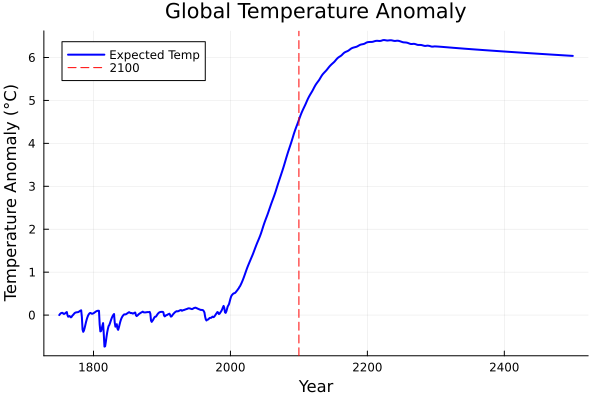

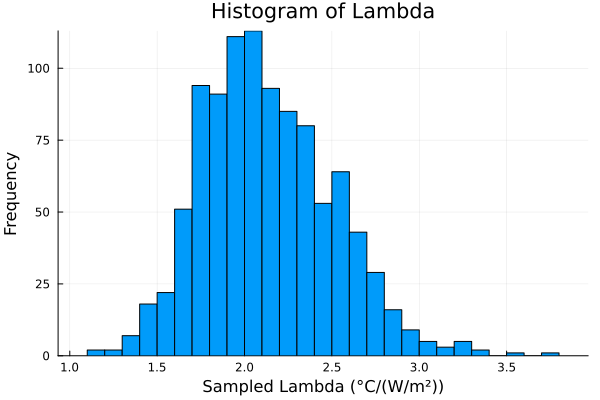

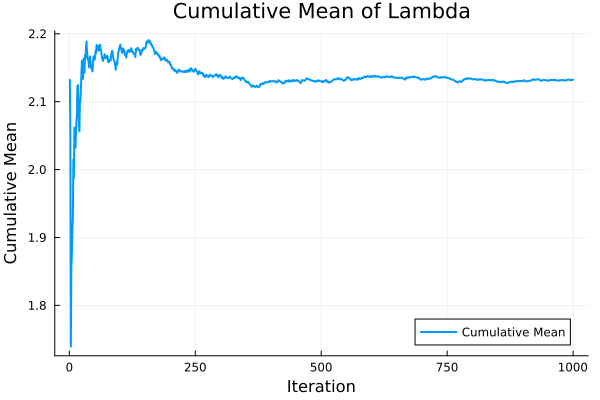

Estimated mean temperature in 2100: 4.603979193131085 °C
95% confidence interval: [3.3362138995015567, 6.260502884350705] °C


In [26]:
using Statistics, Plots, Distributions

# Constants
c, d, dt = 4.184e6, 86, 31_558_152  # Heat, depth, seconds
C, alpha = c * d, 0.8  # Capacity, feedback

# Forcing calcs
forcing_total_with_aerosol = forcing_non_aerosol .+ alpha .* (forcing_aerosol .+ forcing_aerosol)

# Temp sim
function simulate_temperature(lambda, forcing_total, dt, C, length)
    T = zeros(length)
    for t in 2:length
        T[t] = T[t-1] + (dt / C) * (forcing_total[t] - lambda * T[t-1])
    end
    return T
end

# Simulate expected temp
T_expected = simulate_temperature(2.1, forcing_total_with_aerosol, dt, C, length(forcing_total))

# Monte Carlo simu

n_simulations, year_2100_index = 1000, 351 
temperature_2100 = zeros(n_simulations)  # Temp array
lambda_samples = zeros(n_simulations)  # Sampled lambdas

# Sample lambdas, simulate temp
for i in 1:n_simulations
    lambda_samples[i] = rand(LogNormal(log(2.1), log(2) / 4))  
    T_mc = simulate_temperature(lambda_samples[i], forcing_total_with_aerosol, dt, C, length(forcing_total))  # Simulate
    temperature_2100[i] = T_mc[year_2100_index]  #  2100 temp
end

# Mean and CI 
mean_temp_2100, ci_temp_2100 = mean(temperature_2100), quantile(temperature_2100, [0.025, 0.975])

# Prints
println("Estimated mean temperature in 2100: $mean_temp_2100 °C")
println("95% confidence interval: [$(ci_temp_2100[1]), $(ci_temp_2100[2])] °C")

# Plot exp temp
p_forcing = plot(forcings_all[!,"year"], T_expected, xlabel="Year", ylabel="Temperature Anomaly (°C)",
    label="Expected Temp", color=:blue, linewidth=2, title="Global Temperature Anomaly")
vline!([2100], label="2100", linestyle=:dash, color=:red)
display(p_forcing)

# Histogram of lambdas
p_histogram = histogram(lambda_samples, bins=30, xlabel="Sampled Lambda (°C/(W/m²))", ylabel="Frequency",
    title="Histogram of Lambda", legend=false)
display(p_histogram)

# Cumulative mean of lambdas from monte carlo
cumulative_mean_lambda = cumsum(lambda_samples) ./ (1:n_simulations)
p_cumulative_mean = plot(1:n_simulations, cumulative_mean_lambda, xlabel="Iteration", ylabel="Cumulative Mean",
    title="Cumulative Mean of Lambda", label="Cumulative Mean", linewidth=2)
display(p_cumulative_mean)


## References

List any external references consulted, including classmates.